In [1]:
import numpy as np
import cv2
from tools import PlotTools, harris, sobel, sift, matching, ransac
import pylab
import time
import matplotlib as plt

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
imgs = {
    "transA": cv2.imread('inputs/transA.jpg')[:, :, 2],
    "transB": cv2.imread('inputs/transB.jpg')[:, :, 2],
    "simA": cv2.imread('inputs/simA.jpg')[:, :, 2],
    "simB": cv2.imread('inputs/simB.jpg')[:, :, 2]
}


Harris corners
==============
1.1 compute gradients

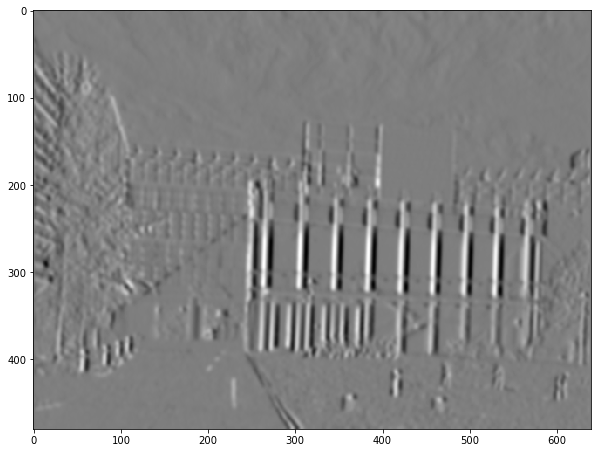

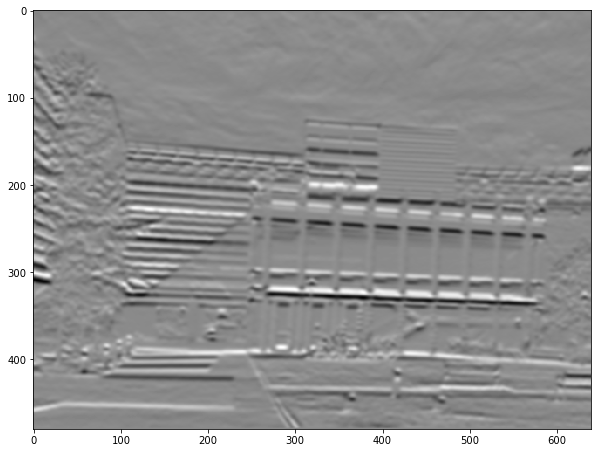

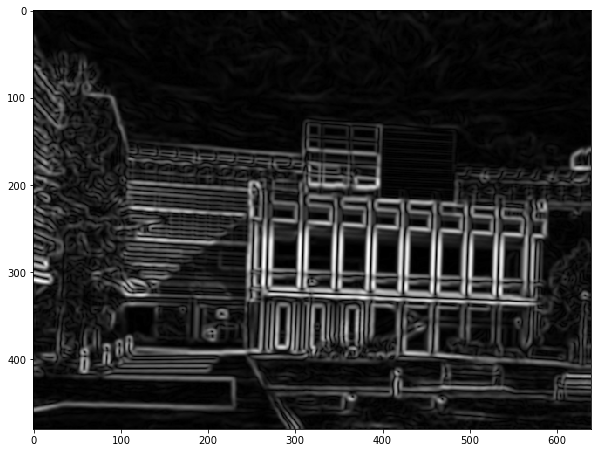

In [3]:
img = imgs["transA"]
imgs["transA_grad"] = sobel.compute_gradients(img, blursize=2, kersize=5)
PlotTools.display_and_save(imgs["transA_grad"][0], "PS4-1-1-transA-I_x")
PlotTools.display_and_save(imgs["transA_grad"][1], "PS4-1-1-transA-I_y")
PlotTools.display_and_save(sobel.get_sobel(imgs["transA_grad"][0], imgs["transA_grad"][1]), "PS4-1-1-transA-sobel")

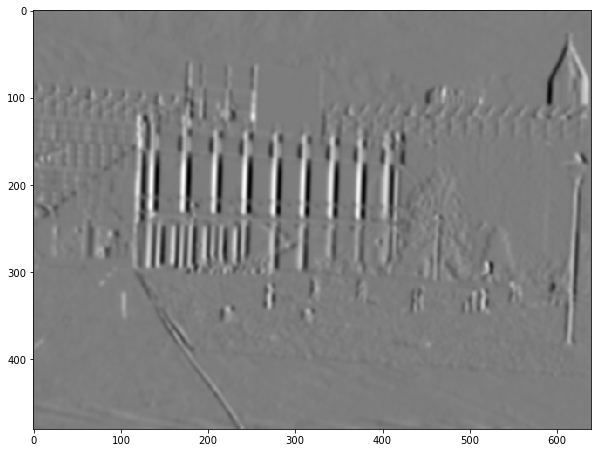

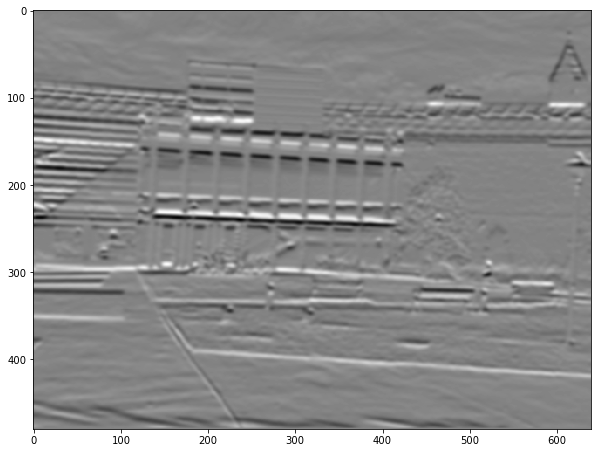

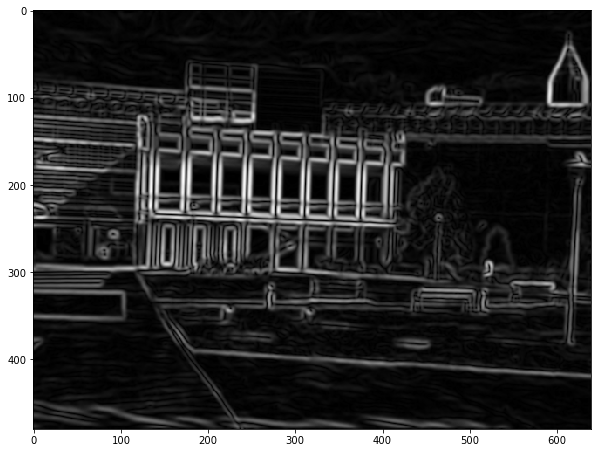

In [4]:
img = imgs["transB"]
imgs["transB_grad"] = sobel.compute_gradients(img, blursize=2, kersize=5)
PlotTools.display_and_save(imgs["transB_grad"][0], "PS4-1-1-transB-I_x")
PlotTools.display_and_save(imgs["transB_grad"][1], "PS4-1-1-transB-I_y")
PlotTools.display_and_save(sobel.get_sobel(imgs["transB_grad"][0], imgs["transB_grad"][1]), "PS4-1-1-transB-sobel")

In [5]:
imgs["simA_grad"] = sobel.compute_gradients(imgs["simA"], blursize=2, kersize=5)
imgs["simB_grad"] = sobel.compute_gradients(imgs["simB"], blursize=2, kersize=5)

1.2 compute the harris values

computation time:  2.343311309814453


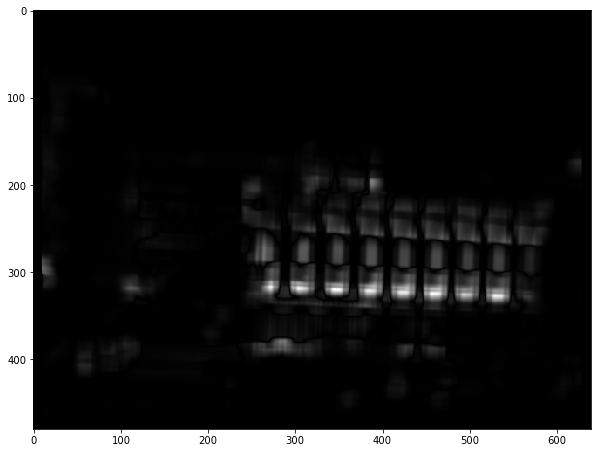

In [6]:
ws = 10
begin = time.time()
imgs["transA_harris"] = harris.harris_cuda_caller(imgs["transA_grad"][0], imgs["transA_grad"][1], wd=ws, alpha=0.05)
imgs["transA_harris"] = np.abs(imgs["transA_harris"])
print("computation time: ", time.time() - begin)
PlotTools.display_and_save(imgs["transA_harris"], "PS4-1-2-transA")

computation time:  1.7715511322021484


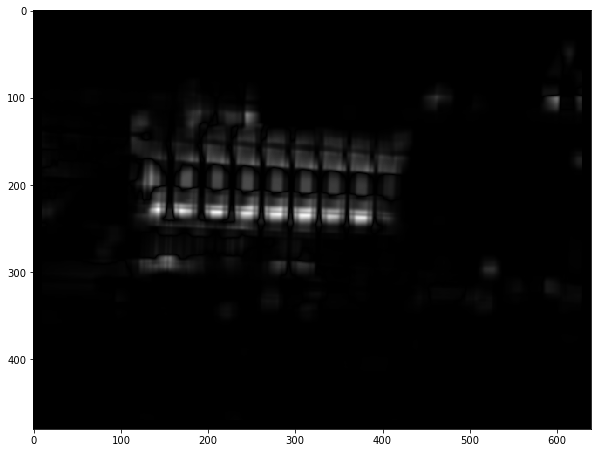

In [7]:
begin = time.time()
imgs["transB_harris"] = harris.harris_cuda_caller(imgs["transB_grad"][0], imgs["transB_grad"][1], wd=ws, alpha=0.05)
imgs["transB_harris"] = np.abs(imgs["transB_harris"])
print("computation time: ", time.time() - begin)
PlotTools.display_and_save(imgs["transB_harris"], "PS4-1-2-transB")

In [8]:
imgs["simA_harris"] = np.abs(harris.harris_cuda_caller(imgs["simA_grad"][0], imgs["simA_grad"][1], wd=ws, alpha=0.05))
imgs["simB_harris"] = np.abs(harris.harris_cuda_caller(imgs["simB_grad"][0], imgs["simB_grad"][1], wd=ws, alpha=0.05))

1.3 Points of interest

number of points: 196


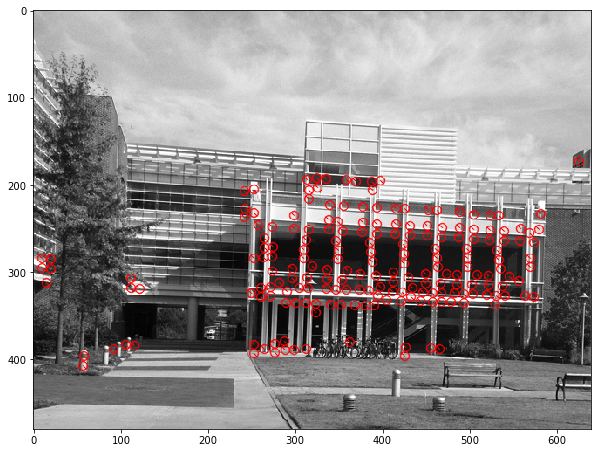

In [9]:
imgs["transA_poi"] = harris.get_maximas(harris_img=imgs["transA_harris"], grad_x=imgs["transA_grad"][0], grad_y=imgs["transA_grad"][0], ws=ws)
print("number of points:", len(imgs["transA_poi"]))
PlotTools.display_and_save(harris.draw_keypoints(imgs["transA"], imgs["transA_poi"]), "PS4-1-3-transA")

number of points: 167


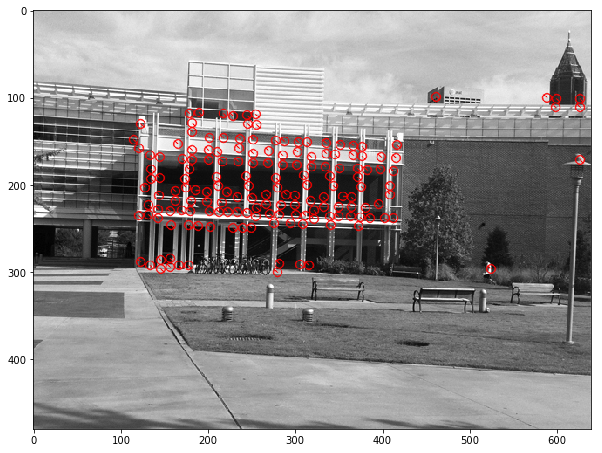

In [10]:
imgs["transB_poi"] = harris.get_maximas(harris_img=imgs["transB_harris"], grad_x=imgs["transB_grad"][0], grad_y=imgs["transB_grad"][0], ws=ws)
print("number of points:", len(imgs["transB_poi"]))
PlotTools.display_and_save(harris.draw_keypoints(imgs["transB"], imgs["transB_poi"]), "PS4-1-3-transB")

number of points: 140


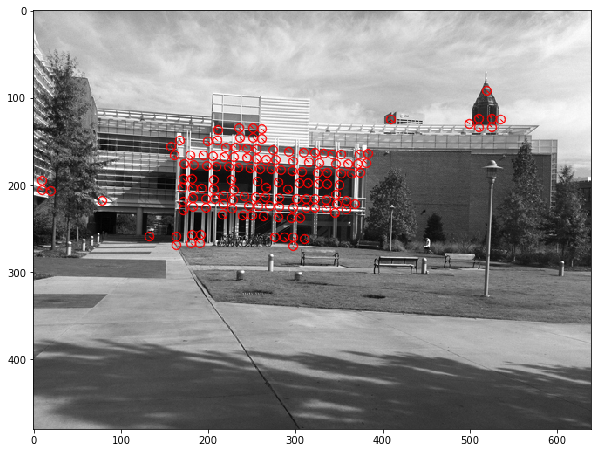

In [11]:
imgs["simA_poi"] = harris.get_maximas(harris_img=imgs["simA_harris"], grad_x=imgs["simA_grad"][0], grad_y=imgs["simA_grad"][0], ws=ws)
print("number of points:", len(imgs["simA_poi"]))
PlotTools.display_and_save(harris.draw_keypoints(imgs["simA"], imgs["simA_poi"]), "PS4-1-3-simA")

number of points: 136


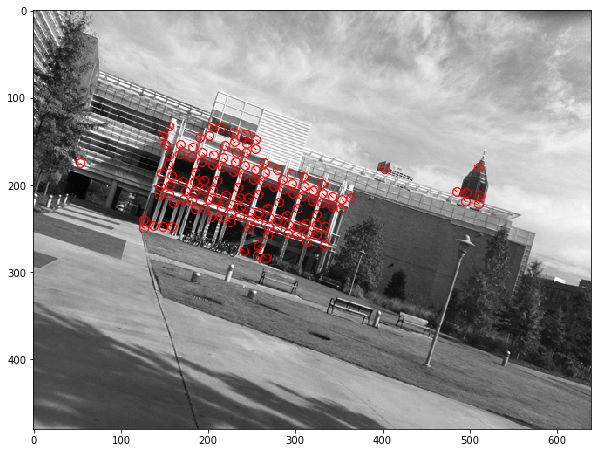

In [12]:
imgs["simB_poi"] = harris.get_maximas(harris_img=imgs["simB_harris"], grad_x=imgs["simB_grad"][0], grad_y=imgs["simB_grad"][0], ws=ws)
print("number of points:", len(imgs["simB_poi"]))
PlotTools.display_and_save(harris.draw_keypoints(imgs["simB"], imgs["simB_poi"]), "PS4-1-3-simB")

We can note that interestingly, most of the gradients are oriented diagonaly. This may be due to the fact that harris corners are in this image mostly crossing of horizontals and vertical lines. Also we can not that most of the points are found in both images when performing both translation or rotation.

SIFT features
=============
2.1 the results are shown on the 1.3 results

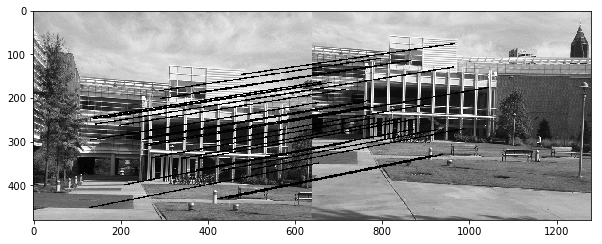

In [13]:
imgA = imgs["transA"]
sift_kp_A, sift_desc_A = sift.get_sift_features(imgA)
imgB = imgs["transB"]
sift_kp_B, sift_desc_B = sift.get_sift_features(imgB)
matches = matching.match(sift_desc_A, sift_desc_B)
putative_img = matching.display_matches(imgA, imgB, sift_kp_A, sift_kp_B, matches)
PlotTools.display_and_save(putative_img, "PS4-2-2-trans")

quality of consensus: 0.235119047619
found transformation [[   1.            0.         -122.6429559 ]
 [   0.            1.          -80.00575498]]


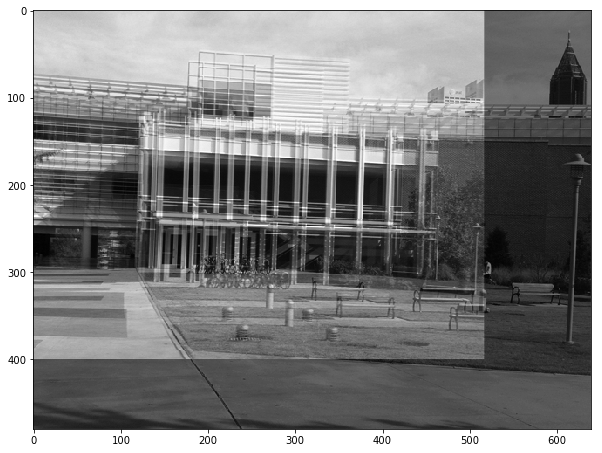

quality of consensus: 0.934523809524
found transformation [[  8.96392092e-01  -1.82913828e-04  -1.01989561e+02]
 [  1.82913828e-04   8.96392092e-01  -5.52042164e+01]]


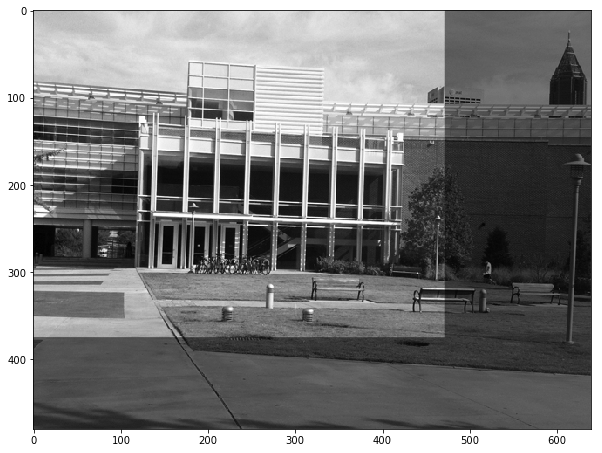

In [14]:
sift_kp_A, sift_desc_A = sift.get_sift_features(imgA)
sift_kp_B, sift_desc_B = sift.get_sift_features(imgB)
matches = matching.match(sift_desc_A, sift_desc_B)
prepared_matches = ransac.prepare_matches_for_ransac(sift_kp_A, sift_kp_B, matches, clean=True)
consensus, M = ransac.ransac(ransac.vote, ransac.compute_model_trans, prepared_matches, s=1, p=0.9, eps=10)
print("quality of consensus:", consensus/len(prepared_matches))
print("found transformation", M)
PlotTools.display_and_save(ransac.superpose_images(imgA, M, imgB), 'PS4-3-1-1')
consensus, M = ransac.ransac(ransac.vote, ransac.compute_model_sim, prepared_matches, s=2, p=0.9, eps=10)
print("quality of consensus:", consensus/len(prepared_matches))
print("found transformation", M)
PlotTools.display_and_save(ransac.superpose_images(imgA, M, imgB), 'PS4-3-1-2')

on the previous result you might note that the real transormation between the two images, in not a simple translation, as the is also a scaling factor. You can see this by looking at the similitude matrix (small rotation, 0.9 scaling factor). You can also note that considering scale, improved alot the measure of the translation factors.

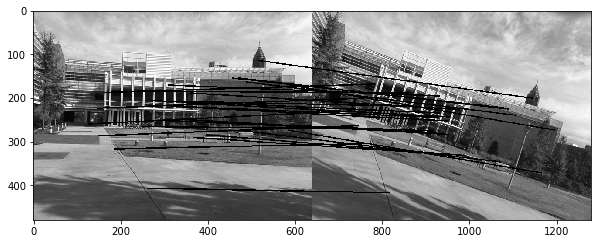

In [15]:
imgA2 = imgs["simA"]
sift_kp_A, sift_desc_A = sift.get_sift_features(imgA2)
imgB2 = imgs["simB"]
sift_kp_B, sift_desc_B = sift.get_sift_features(imgB2)
matches = matching.match(sift_desc_A, sift_desc_B)
putative_img = matching.display_matches(imgA2, imgB2, sift_kp_A, sift_kp_B, matches)
PlotTools.display_and_save(putative_img, "PS4-2-2-sim")

1.09226190476
[[  0.97551264  -0.283282    38.31971848]
 [  0.283282     0.97551264 -59.56724736]]


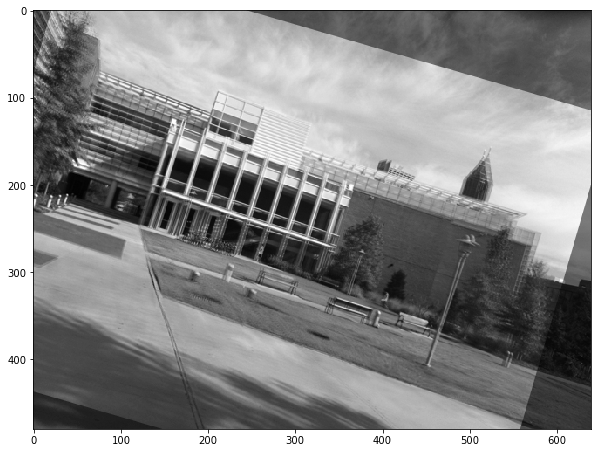

In [16]:
sift_kp_A2, sift_desc_A2 = sift.get_sift_features(imgA2)
sift_kp_B2, sift_desc_B2 = sift.get_sift_features(imgB2)
matches2 = matching.match(sift_desc_A2, sift_desc_B2)
prepared_matches2 = ransac.prepare_matches_for_ransac(sift_kp_A2, sift_kp_B2, matches2, clean=True)
consensus, M2 = ransac.ransac(ransac.vote, ransac.compute_model_sim, prepared_matches2, s=2, p=0.9, eps=10)
print(consensus/len(prepared_matches))
print(M2)
PlotTools.display_and_save(ransac.superpose_images(imgA2, M2, imgB2), 'PS4-3-1-1')

On the last picture you can note that the model used by ransac don't take perspective into account, this is why the two images doesn't fit perfectly, especially on corners. 